# Importación de las librerías necesarias para la ejecución #

In [202]:
#Librerias Necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_val_score, cross_validate

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from scipy.stats import f_oneway
from scipy.stats import kendalltau, spearmanr
from scipy.stats import pointbiserialr

import statsmodels.api as sm
from statsmodels.tools import add_constant

# Lectura de los datos de los partidos ya formateados en .csv

In [203]:
import os

dataframes = []
carpeta = "Datos_Formateados/"  # Reemplaza "ruta/de/la/carpeta" con la ruta de la carpeta que deseas explorar

archivos = os.listdir(carpeta)
for archivo in archivos:
    df = pd.read_csv("Datos_Formateados/"+archivo)
    dataframes.append(df)
datos_partidos = pd.concat(dataframes, ignore_index=True)
datos_partidos.shape

#datos_partidos = pd.read_csv("Datos_Formateados/SP1-2122.csv")
#dataframes = [pd.read_csv("Datos_Formateados/SP1-2122.csv")]

(5240, 17)

In [204]:
print(datos_partidos.shape)
datos_partidos = datos_partidos.dropna()
datos_partidos.shape

(5240, 17)


(5240, 17)

In [205]:
datos_partidos.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HY,AY,HR,AR,FTR
0,SP1,28/08/10,Hercules,Ath Bilbao,0,1,0,0,9,14,3,5,2,4,1,0,A
1,SP1,28/08/10,Levante,Sevilla,1,4,1,2,7,14,4,8,4,4,0,0,A
2,SP1,28/08/10,Malaga,Valencia,1,3,1,1,19,21,5,8,2,5,0,0,A
3,SP1,29/08/10,Espanol,Getafe,3,1,1,0,17,13,8,1,3,4,0,0,H
4,SP1,29/08/10,La Coruna,Zaragoza,0,0,0,0,8,8,2,3,0,1,0,0,D


In [206]:
def get_equipos(dataframe: pd.DataFrame) -> list:
    list = []
    for idx in dataframe.index:
        if dataframe['HomeTeam'][idx] not in list:
            list.append(dataframe['HomeTeam'][idx])
        if dataframe['AwayTeam'][idx] not in list:
            list.append(dataframe['AwayTeam'][idx])
    return list

equipos = get_equipos(dataframe=datos_partidos)
equipos

['Hercules',
 'Ath Bilbao',
 'Levante',
 'Sevilla',
 'Malaga',
 'Valencia',
 'Espanol',
 'Getafe',
 'La Coruna',
 'Zaragoza',
 'Mallorca',
 'Real Madrid',
 'Osasuna',
 'Almeria',
 'Santander',
 'Barcelona',
 'Sociedad',
 'Villarreal',
 'Ath Madrid',
 'Sp Gijon',
 'Granada',
 'Betis',
 'Vallecano',
 'Celta',
 'Valladolid',
 'Elche',
 'Eibar',
 'Cordoba',
 'Las Palmas',
 'Alaves',
 'Leganes',
 'Girona',
 'Huesca',
 'Cadiz']

# Predicción del ganador de un partido 

## - Pre-procesamiento de los datos ##

### Limpiado de valores de la columna FTR diferentes a [A,D,H]

In [79]:
print(datos_partidos.shape)
condicion = (datos_partidos['FTR'] != 'A') & (datos_partidos['FTR'] != 'H') & (datos_partidos['FTR'] != 'D')
datos_partidos = datos_partidos.drop(datos_partidos[condicion].index)
datos_partidos.shape

(5240, 17)


(5240, 17)

### Obtención del gol average medio de cada partido

In [80]:
def get_goles_marcados_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_por_partido = []
    partidos_del_equipo = dataframe.loc[(dataframe['HomeTeam'] == equipo) | (dataframe['AwayTeam'] == equipo)]
    for idx, partido in partidos_del_equipo.iterrows():
        if partido['HomeTeam'] == equipo:
            lista_goles_por_partido.append(partido['FTHG'])
        if partido['AwayTeam'] == equipo:
            lista_goles_por_partido.append(partido['FTAG'])
    return lista_goles_por_partido

def get_goles_encajados_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_por_partido = []
    partidos_del_equipo = dataframe.loc[(dataframe['HomeTeam'] == equipo) | (dataframe['AwayTeam'] == equipo)]
    for idx, partido in partidos_del_equipo.iterrows():
        if partido['HomeTeam'] == equipo:
            lista_goles_por_partido.append(partido['FTAG'])
        if partido['AwayTeam'] == equipo:
            lista_goles_por_partido.append(partido['FTHG'])
    return lista_goles_por_partido

def get_media_gol_average_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_marcados_por_partido = get_goles_marcados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_goles_encajados_por_partido = get_goles_encajados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_gol_average_por_partido = []
    valor_acumulado = 0
    for idx, valor in enumerate(lista_goles_marcados_por_partido):
        lista_media_gol_average_por_partido.append((valor - lista_goles_encajados_por_partido[idx] + valor_acumulado) / (idx+1))
        valor_acumulado += (valor - lista_goles_encajados_por_partido[idx])
    return lista_media_gol_average_por_partido 

def obtencion_porteria_a_cero_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_porterias_a_0 = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_porterias_a_0_por_equipo = []
        porterias_a_0 = 0
        lista_goles_encajados_por_partido = get_goles_encajados_por_partido(dataframe=dataframe, equipo=equipo)
        for goles_encajados in lista_goles_encajados_por_partido:
            if goles_encajados == 0:
                porterias_a_0 += 1
            lista_porterias_a_0_por_equipo.append(porterias_a_0)
        lista_porterias_a_0_por_equipo.insert(0,0)
        dict_ultimo_porterias_a_0_equipo[equipo] = lista_porterias_a_0_por_equipo[-1]
        lista_porterias_a_0_por_equipo.pop()
        lista_listas_porterias_a_0.append(lista_porterias_a_0_por_equipo)
    return lista_listas_porterias_a_0

def get_tiros_a_puerta_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_tiros_por_partido = []
    partidos_del_equipo = dataframe.loc[(dataframe['HomeTeam'] == equipo) | (dataframe['AwayTeam'] == equipo)]
    for idx, partido in partidos_del_equipo.iterrows():
        if partido['HomeTeam'] == equipo:
            lista_tiros_por_partido.append(partido['HST'])
        if partido['AwayTeam'] == equipo:
            lista_tiros_por_partido.append(partido['AST'])
    return lista_tiros_por_partido

def get_media_tiros_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_tiros_por_partido = get_tiros_a_puerta_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_tiros_por_partido = []
    tiros_acumulados = 0
    for idx, valor in enumerate(lista_tiros_por_partido):
        lista_media_tiros_por_partido.append((valor + tiros_acumulados) / (idx+1))
        tiros_acumulados += valor
    return lista_media_tiros_por_partido

def obtencion_tiros_a_puerta_average_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_tiros_average_medio_cada_equipo = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_tiros_average_medio_un_equipo = get_media_tiros_por_partido(dataframe=dataframe, equipo=equipo)
        lista_tiros_average_medio_un_equipo.insert(0,0)
        dict_ultimo_tiros_medios_equipo[equipo] = lista_tiros_average_medio_un_equipo[-1]
        lista_tiros_average_medio_un_equipo.pop()
        lista_listas_tiros_average_medio_cada_equipo.append(lista_tiros_average_medio_un_equipo)
    return lista_listas_tiros_average_medio_cada_equipo

def get_media_goles_marcados_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_por_partido = get_goles_marcados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_goles_por_partido = []
    goles_acumulados = 0
    for idx, valor in enumerate(lista_goles_por_partido):
        lista_media_goles_por_partido.append((valor + goles_acumulados) / (idx+1))
        goles_acumulados += valor
    return lista_media_goles_por_partido

def get_media_goles_encajados_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_por_partido = get_goles_encajados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_goles_por_partido = []
    goles_acumulados = 0
    for idx, valor in enumerate(lista_goles_por_partido):
        lista_media_goles_por_partido.append((valor + goles_acumulados) / (idx+1))
        goles_acumulados += valor
    return lista_media_goles_por_partido  

def media_ultimos_5_partidos(favor: list, contra: list, idx: int):
    return ((favor[idx]-contra[idx])+(favor[idx-1]-contra[idx-1])+(favor[idx-2]-contra[idx-2])+(favor[idx-3]-contra[idx-3])+(favor[idx-4]-contra[idx-4])) /5

def get_media_gol_average_por_partido_ultimos_5(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_marcados_por_partido = get_goles_marcados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_goles_encajados_por_partido = get_goles_encajados_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_gol_average_por_partido = []
    valor_acumulado = 0
    for idx, valor in enumerate(lista_goles_marcados_por_partido):
        if idx <= 4:
            lista_media_gol_average_por_partido.append((valor - lista_goles_encajados_por_partido[idx] + valor_acumulado) / (idx+1))
            valor_acumulado += (valor - lista_goles_encajados_por_partido[idx])
        else:
            lista_media_gol_average_por_partido.append(media_ultimos_5_partidos(favor=lista_goles_marcados_por_partido, contra=lista_goles_encajados_por_partido, idx=idx))

    return lista_media_gol_average_por_partido

def obtencion_gol_average_ultimos_5_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_gol_average_medio_cada_equipo = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_gol_average_medio_un_equipo = get_media_gol_average_por_partido_ultimos_5(dataframe=dataframe, equipo=equipo)
        lista_gol_average_medio_un_equipo.insert(0,0)
        dict_ultimo_gol_average_ultimos_5_equipo[equipo] = lista_gol_average_medio_un_equipo[-1]
        lista_gol_average_medio_un_equipo.pop()
        lista_listas_gol_average_medio_cada_equipo.append(lista_gol_average_medio_un_equipo)
    return lista_listas_gol_average_medio_cada_equipo

def obtencion_gol_average_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_gol_average_medio_cada_equipo = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_gol_average_medio_un_equipo = get_media_gol_average_por_partido(dataframe=dataframe, equipo=equipo)
        lista_gol_average_medio_un_equipo.insert(0,0)
        dict_ultimo_gol_average_equipo[equipo] = lista_gol_average_medio_un_equipo[-1]
        lista_gol_average_medio_un_equipo.pop()
        lista_listas_gol_average_medio_cada_equipo.append(lista_gol_average_medio_un_equipo)
    return lista_listas_gol_average_medio_cada_equipo
        
def get_diferencia_media_gol_average_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_media_gol_average_por_partido = get_media_gol_average_por_partido(dataframe=dataframe, equipo=equipo)
    lista_diferencias = []
    valor_anterior = 0
    for valor in lista_media_gol_average_por_partido:
        lista_diferencias.append(valor - valor_anterior)
        valor_anterior = valor
    return lista_diferencias

def obtencion_diferencias_average_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_diferencias_gol_average_medio_cada_equipo = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_diferencias_gol_average_medio_un_equipo = get_diferencia_media_gol_average_por_partido(dataframe=dataframe, equipo=equipo)
        lista_diferencias_gol_average_medio_un_equipo.insert(0,0) 
        dict_ultimas_diferencias_cada_equipo[equipo] = lista_diferencias_gol_average_medio_un_equipo[-1]
        lista_diferencias_gol_average_medio_un_equipo.pop()
        lista_listas_diferencias_gol_average_medio_cada_equipo.append(lista_diferencias_gol_average_medio_un_equipo)
    return lista_listas_diferencias_gol_average_medio_cada_equipo
        
def get_tarjetas_rojas_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_rojas_por_partido = []
    partidos_del_equipo = dataframe.loc[(dataframe['HomeTeam'] == equipo) | (dataframe['AwayTeam'] == equipo)]
    for idx, partido in partidos_del_equipo.iterrows():
        if partido['HomeTeam'] == equipo:
            lista_rojas_por_partido.append(partido['HR'])
        if partido['AwayTeam'] == equipo:
            lista_rojas_por_partido.append(partido['AR'])
    return lista_rojas_por_partido

def get_media_rojas_por_partido(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_tarjetas_rojas_por_partido = get_tarjetas_rojas_por_partido(dataframe=dataframe, equipo=equipo)
    lista_media_tarjetas_rojas_por_partido = []
    valor_acumulado = 0
    for idx, valor in enumerate(lista_tarjetas_rojas_por_partido):
        lista_media_tarjetas_rojas_por_partido.append((valor + valor_acumulado) / (idx+1))
        valor_acumulado += valor
    return lista_media_tarjetas_rojas_por_partido

def obtencion_rojas_average_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_rojas_por_partido_cada_equipo = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_rojas_por_partido_un_equipo = get_media_rojas_por_partido(dataframe=dataframe, equipo=equipo)
        lista_rojas_por_partido_un_equipo.insert(0,0)
        dict_ultimas_rojas_cada_equipo[equipo] = lista_rojas_por_partido_un_equipo[-1]
        lista_rojas_por_partido_un_equipo.pop()
        lista_listas_rojas_por_partido_cada_equipo.append(lista_rojas_por_partido_un_equipo)
    return lista_listas_rojas_por_partido_cada_equipo

def get_puntos_en_liga_equipo(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_puntos_por_partido = []
    puntos = 0
    partidos_equipo = dataframe.loc[(dataframe['HomeTeam'] == equipo) | (dataframe['AwayTeam'] == equipo)]
    for idx, partido in partidos_equipo.iterrows():
        resultado = partido['FTR']
        if partido['HomeTeam'] == equipo and resultado == 'H':
           puntos += 3 
        elif partido['AwayTeam'] == equipo and resultado == 'A':
           puntos += 3
        elif resultado == 'D':
           puntos += 1
        else:
            puntos += 0
        lista_puntos_por_partido.append(puntos)
    return lista_puntos_por_partido

def get_resultados_partidos_equipo(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_resultados_equipo = []
    victorias = 0
    empates = 0
    derrotas = 0
    partidos_del_equipo = dataframe.loc[(dataframe['HomeTeam'] == equipo) | (dataframe['AwayTeam'] == equipo)]
    for idx, partido in partidos_del_equipo.iterrows():
        if partido['HomeTeam'] == equipo and partido['FTR'] == 'H':
            victorias += 1
        elif partido['AwayTeam'] == equipo and partido['FTR'] == 'A':
            victorias += 1
        elif partido['HomeTeam'] == equipo and partido['FTR'] == 'A':
            derrotas += 1
        elif partido['AwayTeam'] == equipo and partido['FTR'] == 'H':
            derrotas += 1
        else:
            empates += 1
        lista_resultados_equipo.append((victorias,empates,derrotas))
    return lista_resultados_equipo

def obtencion_resultados_en_liga(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_resultados_en_liga = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_resultados_por_partido_un_equipo = get_resultados_partidos_equipo(dataframe=dataframe, equipo=equipo)
        lista_resultados_por_partido_un_equipo.insert(0,(0,0,0))
        dict_ultimos_resultados_cada_equipo[equipo] = lista_resultados_por_partido_un_equipo[-1]
        lista_resultados_por_partido_un_equipo.pop()
        lista_listas_resultados_en_liga.append(lista_resultados_por_partido_un_equipo)
    return lista_listas_resultados_en_liga

def obtencion_puntos_en_liga(dataframe: pd.DataFrame, guardar:bool) -> list:
    lista_listas_puntos_en_liga = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_puntos_por_partido_un_equipo = get_puntos_en_liga_equipo(dataframe=dataframe, equipo=equipo)
        lista_puntos_por_partido_un_equipo.insert(0,0)
        dict_ultimos_puntos_cada_equipo[equipo] = lista_puntos_por_partido_un_equipo[-1]
        lista_puntos_por_partido_un_equipo.pop()
        lista_listas_puntos_en_liga.append(lista_puntos_por_partido_un_equipo)
    return lista_listas_puntos_en_liga
    
def obtencion_media_goles_marcados(dataframe: pd.DataFrame, guardar:bool) -> list:
    lista_listas_goles_marcados = []
    equipos = get_equipos(dataframe=dataframe)
    for equipo in equipos:
        lista_goles_por_partido_un_equipo = get_media_goles_marcados_por_partido(dataframe=dataframe, equipo=equipo)
        lista_goles_por_partido_un_equipo.insert(0,0)
        dict_ultimos_goles_marcados_cada_equipo[equipo] = lista_goles_por_partido_un_equipo[-1]
        lista_goles_por_partido_un_equipo.pop()
        lista_listas_goles_marcados.append(lista_goles_por_partido_un_equipo)
    return lista_listas_goles_marcados
    
def insercion_datos_cada_dataframe(dataframe: pd.DataFrame, lista_listas_gol_average_medio_cada_equipo: list, lista_listas_diferencias_gol_average_medio_cada_equipo: list,
lista_listas_puntos_por_partido: list, lista_listas_goles_marcados_por_partido: list,
lista_listas_resultados_por_partido: list, lista_listas_porterias_a_cero: list,
lista_listas_gol_average_ultimos_5_por_partido: list):
    equipos = get_equipos(dataframe=dataframe)
    for idx_equipos,equipo in enumerate(equipos):
        partidos_del_equipo = dataframe.loc[(dataframe['HomeTeam'] == equipo) | (dataframe['AwayTeam'] == equipo)]
        idx_partidos = 0
        for idx, partido in partidos_del_equipo.iterrows():
            if partido['HomeTeam'] == equipo:
                dataframe.at[idx,'Gol_Average_Home'] = lista_listas_gol_average_medio_cada_equipo[idx_equipos][idx_partidos]
                dataframe.at[idx,'Dif_Home'] = lista_listas_diferencias_gol_average_medio_cada_equipo[idx_equipos][idx_partidos]
                dataframe.at[idx,'Puntos_Home'] = lista_listas_puntos_por_partido[idx_equipos][idx_partidos]
                dataframe.at[idx,'Goles_Marcados_Home'] = lista_listas_goles_marcados_por_partido[idx_equipos][idx_partidos]
                dataframe.at[idx,'Victorias_Home'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][0]
                dataframe.at[idx,'Empates_Home'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][1]
                dataframe.at[idx,'Derrotas_Home'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][2]
                dataframe.at[idx,'Porterias_0_Home'] = lista_listas_porterias_a_cero[idx_equipos][idx_partidos]
                dataframe.at[idx,'Gol_Average_Ultimos_5_Home'] = lista_listas_gol_average_ultimos_5_por_partido[idx_equipos][idx_partidos]
            if partido['AwayTeam'] == equipo:
                dataframe.at[idx,'Gol_Average_Away'] = lista_listas_gol_average_medio_cada_equipo[idx_equipos][idx_partidos]
                dataframe.at[idx,'Dif_Away'] = lista_listas_diferencias_gol_average_medio_cada_equipo[idx_equipos][idx_partidos]
                dataframe.at[idx,'Puntos_Away'] = lista_listas_puntos_por_partido[idx_equipos][idx_partidos]
                dataframe.at[idx,'Goles_Marcados_Away'] = lista_listas_goles_marcados_por_partido[idx_equipos][idx_partidos]
                dataframe.at[idx,'Victorias_Away'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][0]
                dataframe.at[idx,'Empates_Away'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][1]
                dataframe.at[idx,'Derrotas_Away'] = lista_listas_resultados_por_partido[idx_equipos][idx_partidos][2]
                dataframe.at[idx,'Porterias_0_Away'] = lista_listas_porterias_a_cero[idx_equipos][idx_partidos]
                dataframe.at[idx,'Gol_Average_Ultimos_5_Away'] = lista_listas_gol_average_ultimos_5_por_partido[idx_equipos][idx_partidos]
            idx_partidos += 1
    return dataframe    
    
dict_ultimas_diferencias_cada_equipo = {}    
dict_ultimo_gol_average_equipo = {}
dict_ultimas_rojas_cada_equipo = {}
dict_ultimos_puntos_cada_equipo = {}
dict_ultimos_goles_marcados_cada_equipo = {}
dict_ultimos_resultados_cada_equipo = {}
dict_ultimo_porterias_a_0_equipo = {}
dict_ultimo_tiros_medios_equipo = {}
dict_ultimo_gol_average_ultimos_5_equipo = {}
guardar=False
for idx,temporada in enumerate(dataframes):
    if idx == (len(dataframes) - 1):
        guardar = True
    temporada = temporada.dropna()
    lista_listas_gol_average_medio_cada_equipo = obtencion_gol_average_dataframe(dataframe=temporada, guardar=guardar)
    lista_listas_diferencias_gol_average_medio_cada_equipo = obtencion_diferencias_average_dataframe(dataframe=temporada, guardar=guardar)
    lista_listas_puntos_por_partido = obtencion_puntos_en_liga(dataframe=temporada, guardar=guardar)
    lista_listas_goles_marcados_por_partido = obtencion_media_goles_marcados(dataframe=temporada, guardar=guardar)
    lista_listas_resultados_por_partido = obtencion_resultados_en_liga(dataframe=temporada, guardar=guardar)
    lista_listas_porterias_a_cero = obtencion_porteria_a_cero_dataframe(dataframe=temporada, guardar=guardar)
    lista_listas_gol_average_ultimos_5_por_partido = obtencion_gol_average_ultimos_5_dataframe(dataframe=temporada, guardar=guardar)

    dataframe_con_datos_temporada = insercion_datos_cada_dataframe(dataframe=temporada, lista_listas_gol_average_medio_cada_equipo=lista_listas_gol_average_medio_cada_equipo,
                lista_listas_diferencias_gol_average_medio_cada_equipo=lista_listas_diferencias_gol_average_medio_cada_equipo,
                lista_listas_puntos_por_partido=lista_listas_puntos_por_partido,
                lista_listas_goles_marcados_por_partido=lista_listas_goles_marcados_por_partido,
                lista_listas_resultados_por_partido=lista_listas_resultados_por_partido,
                lista_listas_porterias_a_cero=lista_listas_porterias_a_cero,
                lista_listas_gol_average_ultimos_5_por_partido = lista_listas_gol_average_ultimos_5_por_partido)
    dataframes[idx] = dataframe_con_datos_temporada

    
datos_partidos = pd.concat(dataframes)

### Asignación de etiquetas numéricas a los posibles valores de FTR, HomeTeam y AwayTeam

In [81]:
datos_partidos = datos_partidos.drop_duplicates()
datos_partidos.shape

(5240, 35)

In [82]:
lb_make = LabelEncoder()
datos_partidos['target FTR'] = lb_make.fit_transform(datos_partidos['FTR'])
datos_partidos['FTR'].value_counts()
label_encoder = LabelEncoder()
datos_partidos['labeled Home'] = label_encoder.fit_transform(datos_partidos['HomeTeam'])
datos_partidos['labeled Away'] = label_encoder.fit_transform(datos_partidos['AwayTeam'])

In [83]:
datos_partidos['FTR'].value_counts()

FTR
H    2447
A    1480
D    1313
Name: count, dtype: int64

In [84]:
datos_partidos['target FTR'].value_counts()

target FTR
2    2447
0    1480
1    1313
Name: count, dtype: int64

In [111]:
datos_locales = datos_partidos.loc[datos_partidos['FTR'] == 'H']  # Obtiene los índices de las primeras 100 filas que cumplen la condición
datos_empates = datos_partidos.loc[datos_partidos['FTR'] == 'D']  # Obtiene los índices de las primeras 100 filas que cumplen la condición
datos_visitantes = datos_partidos.loc[datos_partidos['FTR'] == 'A']  # Obtiene los índices de las primeras 100 filas que cumplen la condición

dataframes = [datos_empates,datos_visitantes.head(1350), datos_locales.head(1390)]
datos_partidos = pd.concat(dataframes)
datos_partidos = datos_partidos.drop_duplicates()
print(datos_partidos['FTR'].value_counts())
datos_partidos['target FTR'] = lb_make.fit_transform(datos_partidos['FTR'])
datos_partidos['target FTR'].value_counts()

FTR
H    1390
A    1350
D    1313
Name: count, dtype: int64


target FTR
2    1390
0    1350
1    1313
Name: count, dtype: int64

In [112]:
datos_partidos.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,...,Puntos_Away,Goles_Marcados_Away,Victorias_Away,Empates_Away,Derrotas_Away,Porterias_0_Away,Gol_Average_Ultimos_5_Away,target FTR,labeled Home,labeled Away
4,SP1,29/08/10,La Coruna,Zaragoza,0,0,0,0,8,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,17,33
5,SP1,29/08/10,Mallorca,Real Madrid,0,0,0,0,7,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,22,24
6,SP1,29/08/10,Osasuna,Almeria,0,0,0,0,13,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,23,1
15,SP1,12/09/10,Sevilla,La Coruna,0,0,0,0,26,12,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,26,17
19,SP1,13/09/10,Almeria,Sociedad,2,2,1,2,18,15,...,3.0,1.0,1.0,0.0,0.0,1.0,1.0,1,1,27


In [113]:
equipos_locales = datos_partidos['labeled Home'].values
equipos_visitantes = datos_partidos['labeled Away'].values
gol_average_home = datos_partidos['Gol_Average_Home']
gol_average_away = datos_partidos['Gol_Average_Away']
gol_averages = datos_partidos[['Gol_Average_Home','Gol_Average_Away']]
diferencia_home = datos_partidos['Dif_Home']
diferencia_away = datos_partidos['Dif_Away']
diferencias = datos_partidos[['Dif_Home','Dif_Away']]
puntos_home = datos_partidos['Puntos_Home']
puntos_away = datos_partidos['Puntos_Away']
puntos = datos_partidos[['Puntos_Home','Puntos_Away']]
goles_home = datos_partidos['Goles_Marcados_Home']
goles_away = datos_partidos['Goles_Marcados_Away']
goles = datos_partidos[['Goles_Marcados_Home','Goles_Marcados_Away']]
victorias = datos_partidos[['Victorias_Home','Victorias_Away']]
empates = datos_partidos[['Empates_Home','Empates_Away']]
derrotas = datos_partidos[['Derrotas_Home','Derrotas_Away']]
porterias_0_home = datos_partidos['Porterias_0_Home']
porterias_0_away = datos_partidos['Porterias_0_Away']
porterias_0 = datos_partidos[['Porterias_0_Home','Porterias_0_Away']]
columnas_features = ['Gol_Average_Home','Gol_Average_Away','Dif_Home','Dif_Away','Puntos_Home','Puntos_Away','Goles_Marcados_Home','Goles_Marcados_Away',
                     'Victorias_Home','Empates_Home','Derrotas_Home','Victorias_Away','Empates_Away','Derrotas_Away','Porterias_0_Home','Porterias_0_Away',
                     'Gol_Average_Ultimos_5_Home','Gol_Average_Ultimos_5_Away']
features = datos_partidos[columnas_features]
target = datos_partidos['target FTR']

In [114]:
for column in datos_partidos.columns:
    if datos_partidos[column].dtype != 'object':  # Solo características continuas
        groups = [datos_partidos[datos_partidos['target FTR'] == value][column] for value in datos_partidos['target FTR'].unique()]
        f_stat, p_value = f_oneway(*groups)
        print(f'ANOVA para {column}: F-statistic={f_stat}, p-value={p_value}')

ANOVA para FTHG: F-statistic=1564.87993599118, p-value=0.0
ANOVA para FTAG: F-statistic=1337.7280573057803, p-value=0.0
ANOVA para HTHG: F-statistic=610.9663215006525, p-value=1.2807666121401712e-232
ANOVA para HTAG: F-statistic=390.6042273653301, p-value=7.646705082325879e-156
ANOVA para HS: F-statistic=65.16581439672137, p-value=1.3953447467157426e-28
ANOVA para AS: F-statistic=65.25420604713722, p-value=1.2808289583057648e-28
ANOVA para HST: F-statistic=421.77144208722433, p-value=4.064806644134358e-167
ANOVA para AST: F-statistic=397.0584629316667, p-value=3.442085343578745e-158
ANOVA para HY: F-statistic=21.841036718920833, p-value=3.6757583877618133e-10
ANOVA para AY: F-statistic=3.058996906299891, p-value=0.04704320961816137
ANOVA para HR: F-statistic=30.95384096301879, p-value=4.5564537148699505e-14
ANOVA para AR: F-statistic=31.341474883789616, p-value=3.110497860758441e-14
ANOVA para Gol_Average_Home: F-statistic=106.24188356503487, p-value=1.069984308134536e-45
ANOVA para Di

ANOVA para Goles_Marcados_Home: F-statistic=128.21726295155634, p-value=1.0180718427747852e-54
ANOVA para Victorias_Home: F-statistic=50.868371186671546, p-value=1.5172662033412237e-22
ANOVA para Empates_Home: F-statistic=19.238640283472712, p-value=4.832866518718937e-09
ANOVA para Derrotas_Home: F-statistic=17.37344846625759, p-value=3.0689525456378946e-08
ANOVA para Porterias_0_Home: F-statistic=12.567790971315336, p-value=3.6203069493344806e-06
ANOVA para Gol_Average_Ultimos_5_Home: F-statistic=65.69549246763657, p-value=8.353056351757697e-29
ANOVA para Gol_Average_Away: F-statistic=142.51498184227162, p-value=1.5396148614599334e-60
ANOVA para Dif_Away: F-statistic=0.263923625880566, p-value=0.7680454034999734
ANOVA para Puntos_Away: F-statistic=36.58316724992363, p-value=1.7944864492488248e-16
ANOVA para Goles_Marcados_Away: F-statistic=92.7223366203903, p-value=4.225914035229284e-40
ANOVA para Victorias_Away: F-statistic=45.36151419676352, p-value=3.289683765516387e-20
ANOVA para 

c:\Users\User\OneDrive\Escritorio\TFG\Cosas_TFG\.venv\lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [115]:
for column in datos_partidos.columns:
    if datos_partidos[column].dtype != 'object':  # Solo características continuas
        correlation, _ = pointbiserialr(datos_partidos[column], datos_partidos['target FTR'])
        print(f'Correlación de punto biserial para {column}: {correlation}')

Correlación de punto biserial para FTHG: 0.6220865047670865
Correlación de punto biserial para FTAG: -0.603778350806722


Correlación de punto biserial para HTHG: 0.455127291993391
Correlación de punto biserial para HTAG: -0.38734831988828694
Correlación de punto biserial para HS: 0.168421368636293
Correlación de punto biserial para AS: -0.16741589504493384
Correlación de punto biserial para HST: 0.3853869178636249
Correlación de punto biserial para AST: -0.379941590108929
Correlación de punto biserial para HY: -0.09277794879589824
Correlación de punto biserial para AY: 0.023216163768061966
Correlación de punto biserial para HR: -0.12269421414128309
Correlación de punto biserial para AR: 0.1230384182265698
Correlación de punto biserial para Gol_Average_Home: 0.21008404854509263
Correlación de punto biserial para Dif_Home: -0.014859618898399844
Correlación de punto biserial para Puntos_Home: 0.11735459156533702
Correlación de punto biserial para Goles_Marcados_Home: 0.227932102281687
Correlación de punto biserial para Victorias_Home: 0.1469569914079077
Correlación de punto biserial para Empates_Home: -0.09

In [116]:
#target = to_categorical(target) #solo usar si se utiliza la red neuronal como modelo
target.shape

(4053,)

## - Normalización de los datos

Ahora mismo, los dos predictores son variables categóricas de tipo string. Estos no pueden ser alimentados directamente al modelo ya que podría ocasionar algún error. Antes deben ser procesados y convertidos a un valor númerico fácilmente interpretable por el modelo. Para lograr esto, utilizo la opción del **One-shot encoding**

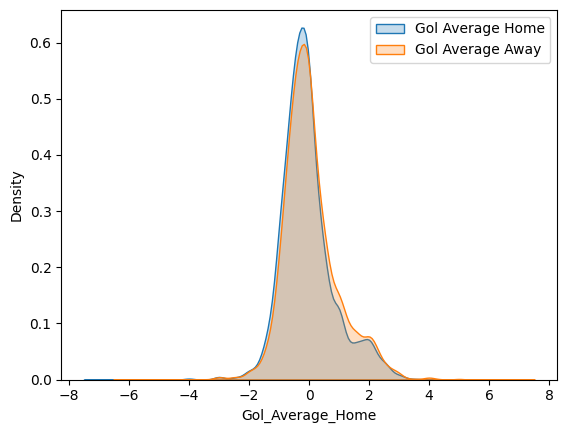

In [117]:
columnas = ['Gol Average Home','Gol Average Away']
for i, col in enumerate(gol_averages.columns):
    sns.kdeplot(gol_averages[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

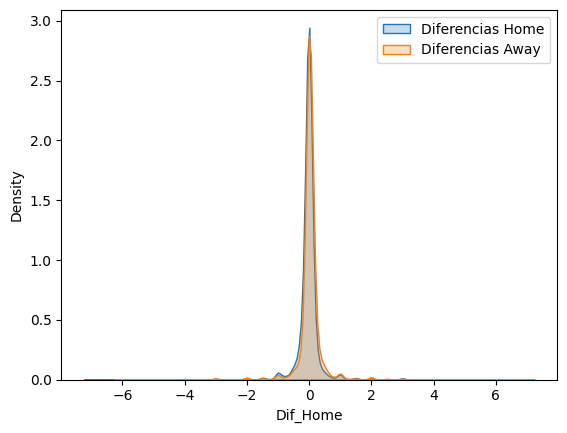

In [118]:
columnas = ['Diferencias Home','Diferencias Away']
for i, col in enumerate(diferencias.columns):
    sns.kdeplot(diferencias[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

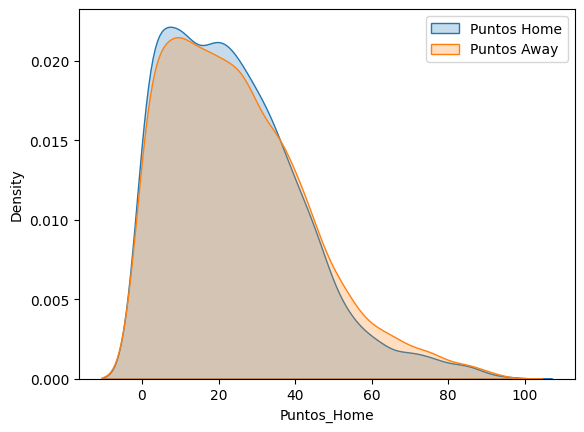

In [119]:
columnas = ['Puntos Home','Puntos Away']
for i, col in enumerate(puntos.columns):
    sns.kdeplot(puntos[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

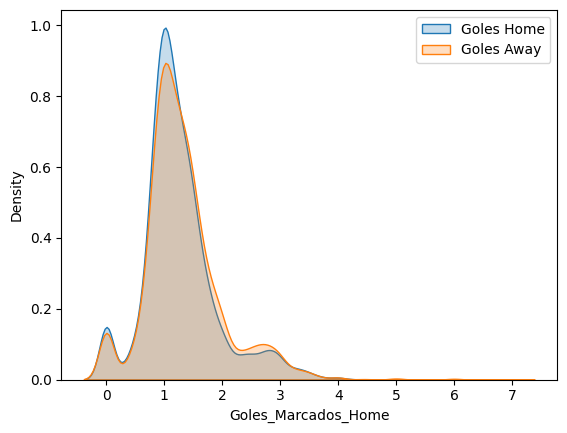

In [120]:
columnas = ['Goles Home','Goles Away']
for i, col in enumerate(goles.columns):
    sns.kdeplot(goles[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

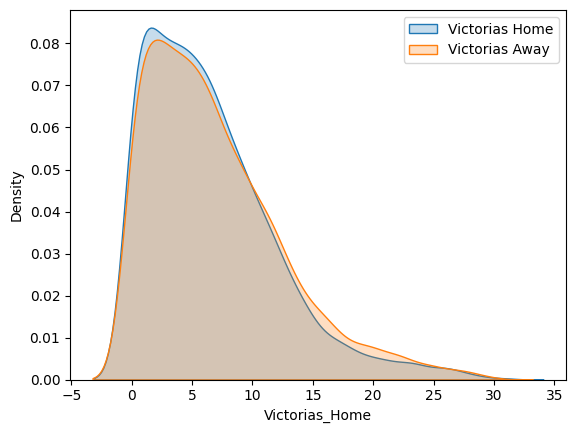

In [121]:
columnas = ['Victorias Home','Victorias Away']
for i, col in enumerate(victorias.columns):
    sns.kdeplot(victorias[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

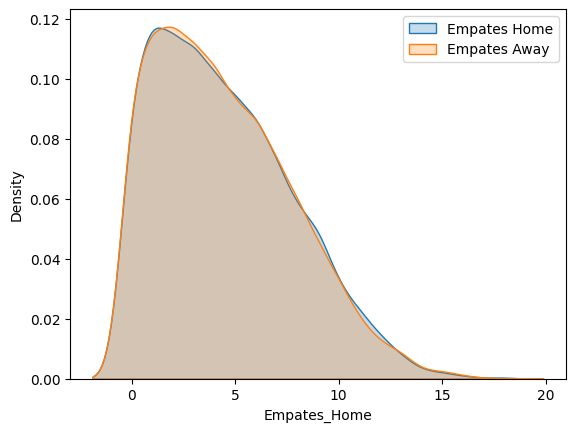

In [122]:
columnas = ['Empates Home','Empates Away']
for i, col in enumerate(empates.columns):
    sns.kdeplot(empates[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

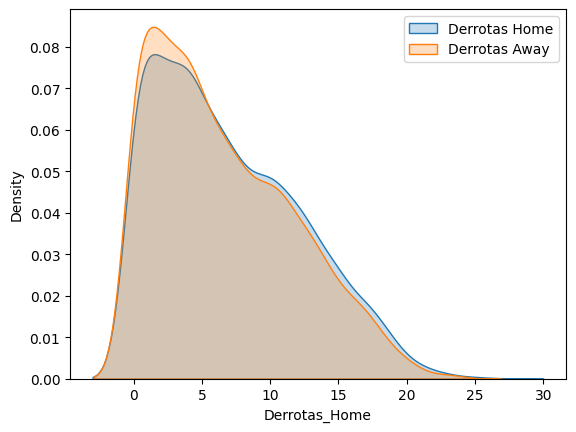

In [123]:
columnas = ['Derrotas Home','Derrotas Away']
for i, col in enumerate(derrotas.columns):
    sns.kdeplot(derrotas[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

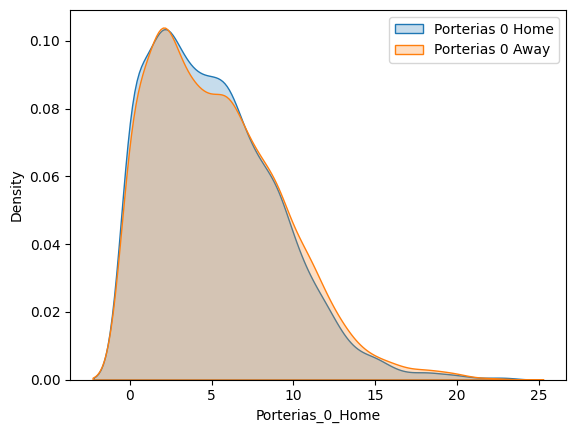

In [124]:
columnas = ['Porterias 0 Home','Porterias 0 Away']
for i, col in enumerate(porterias_0.columns):
    sns.kdeplot(porterias_0[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

In [125]:
scale = MinMaxScaler().fit(features)
features_normalized = scale.transform(features)
features_normalized_dataframe = pd.DataFrame(features_normalized, columns=columnas_features)

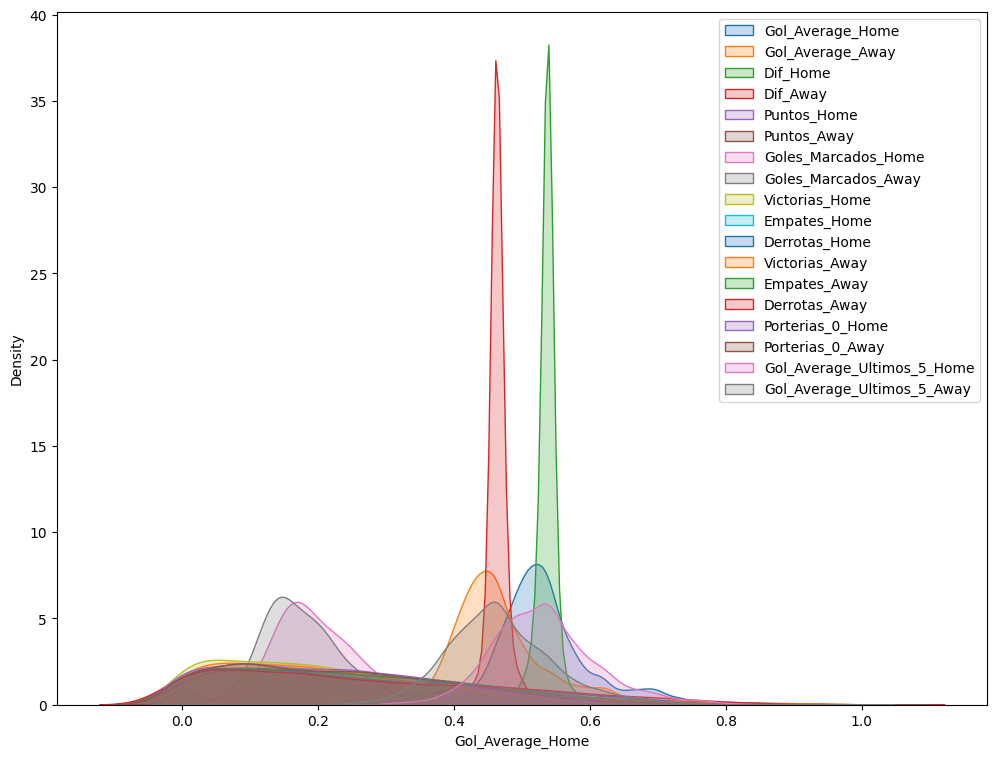

In [126]:
plt.figure(figsize=(12, 9))
for i, col in enumerate(features_normalized_dataframe.columns):
    sns.kdeplot(features_normalized_dataframe[col], fill=True, label=columnas_features[i])
plt.legend()
plt.show()

In [127]:
onehot_encoder = OneHotEncoder(sparse_output=False)
equipos_encoded = onehot_encoder.fit_transform(np.array([equipos_locales, equipos_visitantes]).T)
equipos_encoded.shape

(4053, 68)

In [128]:
predictores = np.concatenate((features_normalized_dataframe[columnas_features].values, equipos_encoded), axis=1)

In [129]:
predictores.shape

(4053, 86)

In [130]:
original_feature_names = list(features_normalized_dataframe[columnas_features].columns)

# Nombres de las características categóricas
categorical_feature_names = ['local_team', 'visitor_team']

# Combina ambas listas
all_feature_names = original_feature_names + categorical_feature_names
equipos_locales = np.array(equipos_locales)
equipos_visitantes = np.array(equipos_visitantes)

# Concatenar las características numéricas con las categóricas
predictores_analisis = np.concatenate((features_normalized_dataframe[columnas_features].values, 
                              equipos_locales.reshape(-1, 1), 
                              equipos_visitantes.reshape(-1, 1)), axis=1)

In [131]:
clf = LogisticRegression(max_iter=40, solver='liblinear', C=10, penalty='l1')
selector = SelectFromModel(estimator=clf, threshold='mean') # puedes ajustar el umbral según lo desees
selector.fit(predictores, target)
predictores_selected = selector.transform(predictores)


## - Entrenamiento del modelo

### División del dataset en entrenamiento y evaluación del modelo

In [132]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),  # Usamos 'macro' para el promedio entre clases
    'precision': make_scorer(precision_score, average='macro')  # Usamos 'macro' para el promedio entre clases
}

In [133]:
features_train, features_test, target_train, target_test = train_test_split( predictores, target, test_size=0.2, random_state=42)
print ('Train set:', features_train.shape,  target_train.shape)
print ('Test set:', features_test.shape,  target_test.shape)

Train set: (3242, 86) (3242,)
Test set: (811, 86) (811,)


### Definición y construcción del modelo

In [134]:
def get_modelo_regresion():
    model = LogisticRegression(max_iter=60, solver='liblinear', C=10, penalty='l1')
    return model

def get_modelo_random_forest():
    model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=20, criterion='log_loss')
    return model

def get_modelo_svc():
    model = SVC(kernel='linear', C=0.5, gamma='scale', probability=True)
    return model

def get_modelo_gbm(): ##mejores resultados pero tarda en entrenar
    model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)  
    return model

def get_modelo_decision_tree():
    model = DecisionTreeClassifier(criterion="log_loss",max_depth=13, random_state=42) 
    return model

def get_modelo_knn(): ##mejor recall en empates
    model = KNeighborsClassifier(n_neighbors=47, metric="minkowski", weights='uniform')
    return model

def get_modelo_naive_bayes():
    #model = GaussianNB()
    model = MultinomialNB()
    return model

def get_modelo_regresion_deep(features: pd.DataFrame) -> Sequential:
    numero_predictores = features.shape[1]
    #Crear el modelo
    model = Sequential()
    model.add(Dense(80, activation='relu', input_shape=(numero_predictores,)))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    #Compilar modelo
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

model = get_modelo_regresion()

### Entrenamiento del modelo

In [135]:
model.fit(features_train, target_train)
#iteraciones=4
#historial_entrenamiento=model.fit(features_train, target_train, validation_data=(features_test,target_test), epochs=iteraciones, verbose=1)

LogisticRegression(C=10, max_iter=60, penalty='l1', solver='liblinear')

In [136]:
#results = cross_validate(model, predictores, target, cv=kf, scoring=scoring, return_train_score=False)

## -Evaluación del modelo

### Evolución del modelo

In [137]:
target_pred = model.predict(features_test)
accuracy = accuracy_score(target_test, target_pred)
recal = recall_score(target_test, target_pred, average=None)
recal_total = recall_score(target_test, target_pred, average='macro')
precision = precision_score(target_test, target_pred, average=None)
precision_total = precision_score(target_test, target_pred, average='macro')
conf_matrix = confusion_matrix(target_test, target_pred)
print("Accuracy del modelo:", accuracy)
print("Recall del modelo:", recal)
print("Recall del modelo:", recal_total)
print("Precision del modelo:", precision)
print("Precision del modelo:", precision_total)
print("Matriz de Confusión:")
print(conf_matrix)

Accuracy del modelo: 0.4722564734895191
Recall del modelo: [0.48363636 0.28571429 0.6640625 ]
Recall del modelo: 0.47780438311688317
Precision del modelo: [0.5        0.42105263 0.47887324]
Precision del modelo: 0.466641957005189
Matriz de Confusión:
[[133  71  71]
 [ 86  80 114]
 [ 47  39 170]]


In [138]:
# print("Accuracy por fold:", results['test_accuracy'])
# print("Recall por fold:", results['test_recall'])
# print("Precision por fold:", results['test_precision'])

# print("\nAccuracy medio:", results['test_accuracy'].mean())
# print("Recall medio:", results['test_recall'].mean())
# print("Precision medio:", results['test_precision'].mean())

# print("\nDesviación estándar de Accuracy:", results['test_accuracy'].std())
# print("Desviación estándar de Recall:", results['test_recall'].std())
# print("Desviación estándar de Precision:", results['test_precision'].std())

## - Predicción real de un partido

In [193]:
#algo le pasa a los predictores que dan cosas muy raras
HT='Sociedad'
AT='Valencia'
point_average_home = dict_ultimo_gol_average_equipo[HT]
point_average_away = dict_ultimo_gol_average_equipo[AT]
dif_home = dict_ultimas_diferencias_cada_equipo[HT]
dif_away = dict_ultimas_diferencias_cada_equipo[AT]
average_point_scored_home = dict_ultimos_goles_marcados_cada_equipo[HT]
average_point_scored_away = dict_ultimos_goles_marcados_cada_equipo[AT]
clean_matches_home = dict_ultimo_porterias_a_0_equipo[HT]
clean_matches_away = dict_ultimo_porterias_a_0_equipo[AT]
point_average_last5_home = dict_ultimo_gol_average_ultimos_5_equipo[HT]
point_average_last5_away = dict_ultimo_gol_average_ultimos_5_equipo[AT]
victories_home = dict_ultimos_resultados_cada_equipo[HT][0]
victories_away = dict_ultimos_resultados_cada_equipo[AT][0]
empates_home = dict_ultimos_resultados_cada_equipo[HT][1]
empates_away = dict_ultimos_resultados_cada_equipo[AT][1]
defeats_home = dict_ultimos_resultados_cada_equipo[HT][2]
defeats_away = dict_ultimos_resultados_cada_equipo[AT][2]
competition_score_home = dict_ultimos_puntos_cada_equipo[HT]
competition_score_away = dict_ultimos_puntos_cada_equipo[AT]

datos_partido = np.array([
    point_average_home, point_average_away, dif_home, dif_away, competition_score_home, competition_score_away, average_point_scored_home,
    average_point_scored_away, victories_home, empates_home, defeats_home, victories_away, empates_away,
    defeats_away, clean_matches_home, clean_matches_away, point_average_last5_home, point_average_last5_away   
]).reshape(1, -1)
datos_partido.shape



(1, 18)

In [194]:
datos_partido = scale.transform(datos_partido)
datos_partido

c:\Users\User\OneDrive\Escritorio\TFG\Cosas_TFG\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.56923077, 0.46410256, 0.54005305, 0.46410256, 0.50515464,
        0.46808511, 0.23888889, 0.15714286, 0.41935484, 0.55555556,
        0.25925926, 0.4       , 0.44444444, 0.41666667, 0.52173913,
        0.47826087, 0.55384615, 0.47692308]])

### Normalizar los predictores teniendo en cuenta los predictores usados para el entrenamiento del modelo

In [195]:
local = [HT,]
visitante = [AT,]
locales_encoded = label_encoder.transform(local)
visitantes_encoded = label_encoder.transform(visitante)

equipos_encoded = onehot_encoder.transform(np.array([locales_encoded, visitantes_encoded]).T)
equipos_encoded.shape

(1, 68)

In [196]:
predictores = np.concatenate((datos_partido, equipos_encoded), axis=1)
predictores.shape

(1, 86)

### Predicción del valor objetivo

In [197]:
prediction = model.predict_proba(predictores)
prediction

array([[0.29416911, 0.47068393, 0.23514696]])

### Conversión del número devuelto
Puede que el valor de las probabilidades devuelto por el modelo sea muy pequeño así que se opera para ser un número más manejable

In [198]:
def convertir_numbero(prediccion: list) -> list:
    prediccion_valores=[]
    for i in range(len(prediccion[0])):
      pred_number=float(format(prediccion[0][i], '.3f'))
      prediccion_valores.append(pred_number)

    return (prediccion_valores)
  
pred_number_probabilities=convertir_numbero(prediction)

### Obtención del resultado predicho en base a las probabilidades predichas por el modelo

In [199]:
def get_ganador_prediccion(ganador: list) -> str:
    y=ganador.index(max(ganador))
    if y==0:
        pred_winner='Away'
    elif y==1:
        pred_winner='Draw'
    else:
        pred_winner='Home'
    return pred_winner

ganador_predicho=get_ganador_prediccion(pred_number_probabilities)

### Resultado Final

In [200]:
print('El ganador predicho es: ',ganador_predicho)

El ganador predicho es:  Draw


### Visualización de las probabilidades en una gráfica

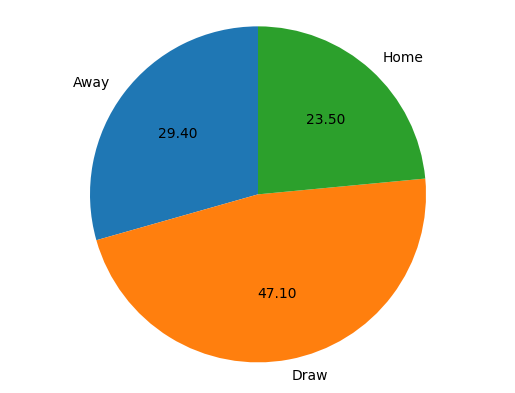

In [201]:
etiquetas = 'Away', 'Draw', 'Home'
figureObject, axesObject = plt.subplots()
axesObject.pie(pred_number_probabilities, labels=etiquetas, autopct='%1.2f', startangle=90)
axesObject.axis('equal') # Aspect ratio equal means pie is a circle
plt.show()